In [1]:
import os
from pathlib import Path
from typing import Any, Dict, Iterable, List, Optional, Tuple, Union

import necstdb
import numpy as np
import xarray as xr
from astropy.coordinates import SkyCoord
from astropy.time import Time
from neclib.coordinates import parse_frame
from neclib.coordinates import PointingError
from neclib import config


def load(
    path: os.PathLike,
    transform: Optional[str] = None,
    total_power: bool = True,
) -> "SpectralTimeseries":
    st = SpectralTimeseries.from_path(path)
    if transform is not None:
        transform = [transform] if isinstance(transform, str) else transform
        [st.transform(t, st.pointing_parameter_path) for t in transform]
    if total_power:
        st.total_power()
    return st


class SpectralTimeseries:

    spectral_tables = [
        "necst-OMU1P85M-data-spectral-board3",
        "necst-OMU1P85M-data-spectral-board4",
    ]
    encoder_table = "necst-OMU1P85M-ctrl-antenna-encoder"

    location = config.location

    def __init__(self, db: necstdb.necstdb.necstdb) -> None:
        self.db = db

        os.environ["NECST_ROOT"] = str(db.path.parent)
        config.reload()
        self.pointing_parameter_path = config.antenna_pointing_parameter_path

        self.data = xr.Dataset(coords={"time": self.time_index})

        _coord = {k: f"{self.spectral_tables[0]}.{k}" for k in ["position", "id"]}
        _coord.update({k: f"{self.encoder_table}.{k}" for k in ["lon", "lat"]})

        _data_col = {t.split("-")[-1]: f"{t}.data" for t in self.spectral_tables}
        _data_col.update({k: f"{self.encoder_table}.{k}" for k in ["lon", "lat"]})

        self.add_coord(**_coord)
        self.add_column(**_data_col)
        self.transform("altaz", self.pointing_parameter_path)

    @classmethod
    def from_path(cls, path: os.PathLike, *args, **kwargs) -> "SpectralTimeseries":
        db = necstdb.opendb(path)
        return cls(db, *args, **kwargs)

    #def _repr_html_(self) -> str:
    #    return f"{self.__class__.__name__}<br>" + self.data._repr_html_()

    @property
    def time_index(self) -> np.ndarray:
        t = self.db.open_table(self.spectral_tables[0]).read(astype="sa", cols=["time"])
        return t["time"]

    def _dims(self, ndim: int = 1) -> List[str]:
        return ["time", "spec", ...][:ndim]

    
    def _to_dataarray(
        self, data: Iterable, time_coord: Optional[Iterable[float]] = None
    ) -> xr.DataArray:
        data = np.asarray(data)
        dims = self._dims(data.ndim)
        if time_coord is not None:
            da = xr.DataArray(data, coords={"time": time_coord}, dims=dims)
            try:
                return da.interp({"time": self.time_index})
            except TypeError:
                return da.reindex({"time": self.time_index}, method="ffill")
        return xr.DataArray(data, coords={"time": self.time_index}, dims=dims)
    
    def _read(self, **kwargs) -> Dict[str, np.ndarray]:
        ret = {}
        for colname, dbname in kwargs.items():
            table, field = dbname.split(".")

            field = [field] if isinstance(field, str) else field
            field = ["time", *field] if "time" not in field else field

            data = self.db.open_table(table).read(astype="sa")

            coord = data["time"]
            field.remove("time")
            for f in field:
                da = self._to_dataarray(data[f], time_coord=coord)
                ret[colname] = da

        return ret
    
    def add_coord(self, **kwargs) -> None:
        self.data = self.data.assign_coords(self._read(**kwargs))
    
    def add_column(self, **kwargs) -> None:
        self.data = self.data.assign(self._read(**kwargs))

    def transform(
        self,
        new_frame: str,
        pointing_param: Optional[Union[os.PathLike, Dict[str, Any]]] = None,
    ) -> Optional[Tuple[np.ndarray, np.ndarray]]:
        lon, lat = self.data["lon"], self.data["lat"]
        if pointing_param is None:
            pe = PointingError("omu1p85m")
        elif isinstance(pointing_param, (str, Path)):
            pe = PointingError.from_file(pointing_param)
        else:
            pe = PointingError(**pointing_param)

        lon, lat = pe.apparent_to_refracted(lon, lat, unit="deg")
        obstime = Time(self.time_index, format="unix")
        new_frame = parse_frame(new_frame)

        """print("aaaaaaaaaaaaaaaaaaaalon,lat,location,obstime="+str(lon)+","+str(lat))
        print(","+str(self.location))
        print(","+str(obstime))"""

        coord = SkyCoord(
            lon, lat, frame="altaz", location=self.location, obstime=obstime
        ).transform_to(new_frame)

        dims = self._dims(coord.data.lon.ndim)
        name = {v: k for k, v in coord.representation_component_names.items()}
        self.data = self.data.assign_coords(
            {name["lon"]: (dims, coord.data.lon.to_value("deg"))}
        )
        self.data = self.data.assign_coords(
            {name["lat"]: (dims, coord.data.lat.to_value("deg"))}
        )
    
    def total_power(self) -> Optional[xr.DataArray]:
        for table in map(lambda x: x.split("-")[-1], self.spectral_tables):
            self.data[f"total-{table}"] = self.data[table].sum(dim="spec")
    
    def ndimensional(self, ndim: int) -> xr.Dataset:
        da = {k: v for k, v in self.data.data_vars.items() if v.ndim == ndim}
        return xr.Dataset(da, coords=self.data.coords)
    


2024-10-16 19:47:48,622: [ERROR: configuration.py#L228] No telescope specified, using default config....
2024-10-16 19:47:48,623: [INFO: configuration.py#L236] Importing configuration from '/Users/koutamac-academic/.necst/config.toml'


In [2]:
import math
import time
from logging import Logger, getLogger
from typing import Any, Iterable, Optional, Tuple, Union

import astropy.units as u
import matplotlib.pyplot as plt
import necstdb
import numpy as np
import xarray as xr
from neclib import config
from neclib.coordinates import CoordCalculator, Observer



#def spectral_table(db: necstdb.necstdb.necstdb) -> list[str]:
#    return [key for key in db.list_tables() if key.find("-data-spectral-") != -1]


def layout(__targets: Union[int, Iterable[Any]], /) -> Tuple[int, int]:
    n = __targets if isinstance(__targets, int) else len(__targets)
    return math.ceil(n / math.ceil(math.sqrt(n))), math.ceil(math.sqrt(n))


def get_logger(name: Optional[str] = None) -> Logger:
    return getLogger(name)


def channel(
    species: str,
    vlsr: u.Quantity,
    target: str,
    freq_1st_lo: u.Quantity = 18.75 * u.GHz,
    factor_1st_lo: int = 12,
    freq_2nd_lo: u.Quantity = 4 * u.GHz,
    freq_resolution: u.Quantity = 2 * u.GHz / 2**15,
    obstime: Optional[float] = None,
) -> u.Quantity:
    rest_freq = {
        "12CO_J2-1": 230.538000 * u.GHz,
        "13CO_J2-1": 220.398681 * u.GHz,
        "C18O_J2-1": 219.560354 * u.GHz,
        "12CO_J1-0": 115.271202 * u.GHz,
        "13CO_J1-0": 110.201353 * u.GHz,
        "C18O_J1-0": 109.782173 * u.GHz,
    }

    if obstime is None:
        obstime = time.time()

    obs = Observer(config.location)
    coord = CoordCalculator(config.location)
    coordinate = coord.name_coordinate(target, [obstime, obstime + 1])
    c = coordinate.realize(time=obstime)

    az, el, t = c.lon, c.lat, c.time

    los_velocity = vlsr - obs.v_obs(lon=az, lat=el, time=t, frame="altaz", unit="deg")
    freq_to_velocity_equiv = u.doppler_radio(rest_freq[species])
    observed_rf = los_velocity.to(u.GHz, equivalencies=freq_to_velocity_equiv)
    observed_if = abs(abs(observed_rf - freq_1st_lo * factor_1st_lo) - freq_2nd_lo)
    return observed_if / freq_resolution


def figureof(
    __target, /, size: Union[int, float] = 3.0, **kwargs
) -> Tuple[plt.Figure, plt.Axes]:
    _layout = layout(__target)
    fig, ax = plt.subplots(
        *_layout, figsize=[size * d for d in _layout[::-1]], **kwargs
    )
    return fig, ax


def text(ax: plt.Axes, text: str, loc: str = "lower right", **kwargs) -> plt.Text:
    locs = {
        "upper left": [(0.04, 0.96), {"ha": "left", "va": "top"}],
        "upper right": [(0.96, 0.96), {"ha": "right", "va": "top"}],
        "lower left": [(0.04, 0.04), {"ha": "left", "va": "bottom"}],
        "lower right": [(0.96, 0.04), {"ha": "right", "va": "bottom"}],
    }
    return ax.text(
        *locs[loc][0],
        text,
        **locs[loc][1],
        transform=ax.transAxes,
        backgroundcolor="#FFF7",
        zorder=10,
        **kwargs,
    )


def stamp(fig: plt.Figure, data: SpectralTimeseries) -> plt.Text:
    return fig.text(
        0, 1, f"{data.db.path.name}", font="monospace", ha="left", va="bottom"
    )


#def group_timeseries(da: xr.DataArray, col: str) -> xr.DataArray:
#    (idx,) = np.where(da[col] != da[col].shift({"time": 1}))
#    idx = np.r_[idx, None]
#    for i in range(len(idx) - 1):
#        yield da.isel(time=slice(idx[i], idx[i + 1]))



In [3]:
import os
import re
import warnings
from typing import Iterable, Optional, Tuple, Union

import astropy.units as u
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
from neclib import get_logger
from neclib.coordinates.observations.observation_spec_base import ObservationSpec
from scipy.optimize import OptimizeWarning, curve_fit
from neclib.core import Parameters


scan_matcher = re.compile(rb"[xy]-|^-?[\d\s]*$")
point_matcher = re.compile(rb"(-?\d)-(-?\d)")

logger = get_logger(__name__)


def radio_pointing(
    path: str,
    specpath: Union[str, os.PathLike],
    baseline_deg: int = 1,
    nofit: Optional[Union[slice, Iterable[slice]]] = None,
    specrange: Optional[Union[slice, Iterable[slice]]] = None,
) -> Tuple[plt.Figure, plt.Axes]:
    db = load(path)
    spectral = db.ndimensional(2)
    #spec = ObservationSpec.from_file(specpath)
    spec = Parameters.from_file(specpath)
    scan = spec.method < 0

    fig, axes = figureof(spectral, size=5)
    if specrange is None or isinstance(specrange, slice):
        specrange = [specrange] * len(spectral.data_vars)
    for ax, _specrange, (name, data) in zip(
        axes.flat, specrange, spectral.data_vars.items()
    ):
        if scan:
            _radio_pointing_scan(ax, data, spec, baseline_deg)
        else:
            _radio_pointing_point(ax, data, spec, _specrange, nofit, baseline_deg)
    stamp(fig, db)
    fig.tight_layout()
    return fig, axes


def _radio_pointing_scan(
    ax: plt.Axes,
    data: np.ndarray,
    spec: ObservationSpec,
    baseline_deg: int = 1,
) -> plt.Axes:
    ...


def _radio_pointing_point(
    ax: plt.Axes,
    data: xr.DataArray,
    spec: ObservationSpec,
    specrange: Optional[slice] = None,
    nofit: Optional[Union[slice, Iterable[slice]]] = None,
    baseline_deg: int = 1,
) -> plt.Axes:
    n_per_axis = int((spec.method + 1) / 2)
    position = np.linspace(0, 1, n_per_axis + 1)[:-1]
    center_idx = int((n_per_axis - 1) / 2)
    top_left = [(p, position[center_idx]) for p in position] + [
        (position[center_idx], p) for p in position
    ]
    width = height = 1 / n_per_axis

    inset_axes = [ax.inset_axes([x0, y0, width, height]) for x0, y0 in top_left]
    _ = [_ax.set(xticks=[], yticks=[]) for _ax in inset_axes]

    hot = off = None
    axes = iter(inset_axes)
    integ_x, integ_y, x, y = [], [], [], []
    offset = {str(i): v for i, v in enumerate(pointing_position(spec))}
    for key, _data in data.groupby("id"):
        key = key.strip()
        id_match = point_matcher.match(key)
        if id_match is None:
            cycle, ident = -1, key
        else:
            cycle, ident = id_match.groups()

        _data = _data.assign_coords(cycle=cycle, ident=ident)
        if specrange is not None:
            _data = _data.isel(spec=specrange, drop=True)
        hotdata = _data.where(_data["position"] == b"HOT     ", drop=True)
        offdata = _data.where(_data["position"] == b"OFF     ", drop=True)
        ondata = _data.where(_data["position"] == b"ON      ", drop=True)
        if len(hotdata) > 0:
            hot = hotdata.mean("time")
        if len(offdata) > 0:
            off = offdata.mean("time")
        if len(ondata) > 0:
            on = ondata
            try:
                _ax = next(axes)
            except StopIteration:
                _ax = None
        else:
            continue

        if all(x is not None for x in (hot, off)):
            on = (on - off) / (hot - off) * 273
        if (specrange is not None) and (baseline_deg > 0):
            _baseline = baseline(
                on.spec, on.mean("time"), nofit=nofit, baseline_deg=baseline_deg
            )
            on -= _baseline

        _offset = offset.get(ident.decode(), None)
        if _offset is None:
            continue
        integ = on.sum("spec").values
        if _offset[2] == "y":
            integ_y = np.r_[integ_y, integ]
            y = np.r_[y, np.broadcast_to(_offset[1].to_value("arcsec"), integ.shape)]
        else:
            integ_x = np.r_[integ_x, integ]
            x = np.r_[x, np.broadcast_to(_offset[0].to_value("arcsec"), integ.shape)]

        if _ax is not None:
            onmean = on.mean("time")
            _ax.plot(on.spec, onmean, color="#03FB" if _offset[2] == "x" else "#F30B")
            text(_ax, f"{u.Quantity(_offset[:2])}", "lower right", fontsize=6)
            if (specrange is None) or (baseline_deg < 0):
                _ax.set(ylim=np.quantile(onmean, [0.01, 0.99]))

    ylims = []
    _ = [ylims.extend(_ax.get_ylim()) for _ax in inset_axes]
    ylim = (min(ylims), max(ylims))
    _ = [_ax.set(ylim=ylim, facecolor="#FFF3") for _ax in inset_axes]
    _ = [_ax.axhline(0, c="#777", ls=":") for _ax in inset_axes]

    popt_x = fit(x, integ_x)
    popt_y = fit(y, integ_y)
    text(ax, f"dAz: {popt_x[1]:.3f} arcsec\ndEl: {popt_y[1]:.3f} arcsec", "lower right")

    ax.set(xticks=[], yticks=[], title=data.name)
    ax.grid(False)
    return ax


def pointing_position(spec: ObservationSpec) -> Iterable[Tuple[u.Quantity, u.Quantity]]:
    separation_x, separation_y = spec.grid_az, spec.grid_el
    n_per_arm = int((spec.method - 1) / 4)
    for offset in range(-n_per_arm, n_per_arm + 1):
        yield (offset * separation_x, 0.0 * separation_x.unit, "x")
    for offset in range(-n_per_arm, n_per_arm + 1):
        yield (0.0 * separation_y.unit, offset * separation_y, "y")


def gaussian(x, amp, mu, sigma):
    return amp * np.exp(-((x - mu) ** 2) / (2 * sigma**2))


def fit(
    x: list[Union[int, float]], y: list[Union[int, float]]
) -> Tuple[float, float, float]:
    with warnings.catch_warnings():
        warnings.simplefilter(action="error")
        try:
            p0 = ((y.max() - y.min()), x.mean(), (x.max() - x.min()) / 2)
            popt, pcov = curve_fit(gaussian, x, y, p0=p0)
        except (OptimizeWarning, RuntimeError):
            logger.warning("Failed to fit gaussian")
            popt = np.full(3, np.nan)
    return popt


def baseline(
    x: list[Union[int, float]],
    y: list[Union[int, float]],
    nofit: Optional[Union[slice, Iterable[slice]]] = None,
    baseline_deg: int = 1,
) -> np.ndarray:
    if nofit is None:
        length = len(x)
        trisection = [int(i * length / 3) for i in range(4)]
        nofit = slice(trisection[1], trisection[2])
    if isinstance(nofit, slice):
        nofit = [nofit]

    array_kw = dict(copy=True, dtype=np.float32)
    fit_x, y = np.array(x, **array_kw), np.array(y, **array_kw)
    for _slice in nofit:
        fit_x[_slice] = np.nan
        y[_slice] = np.nan
    fit_x, y = fit_x[~np.isnan(fit_x)], y[~np.isnan(y)]
    return np.polynomial.Polynomial(np.polyfit(fit_x, y, baseline_deg)[::-1])(x)


{'model': 'nanten2', 'dAz[arcsec]': 5314.2466754691195, 'de[arcsec]': 382, 'chi_Az[arcsec]': -27.743114809726713, 'omega_Az[deg]': -10.004233550100272, 'eps[arcsec]': -13.562343977659976, 'chi2_Az[arcsec]': -3.228334593006749, 'omega2_Az[deg]': -34.73486665318979, 'chi_El[arcsec]': -30.04638718961787, 'omega_El[deg]': -16.233694100299584, 'chi2_El[arcsec]': -1.1446000035021269, 'omega2_El[deg]': -41.47487448160142, 'g': -0.1722057480172642, 'gg': 0.0, 'ggg': 0.0, 'gggg': 0.0, 'dEl[arcsec]': 6520.23761178072, 'de_radio[arcsec]': -394.46, 'del_radio[arcsec]': 210.7228, 'cor_v[arcsec]': 27.434, 'cor_p[deg]': -31.6497, 'g_radio': -0.454659, 'gg_radio': 0.0128757, 'ggg_radio': 0.0, 'gggg_radio': 0.0}
{'observer': 'amigos', 'target': 'Orion KL', 'species': 'J21_12CO', 'lambda_on[deg]': 83.809, 'beta_on[deg]': -5.372639, 'relative': False, 'lambda_off[deg]': 82.55910596, 'beta_off[deg]': -5.66845794, 'delta_lambda': {}, 'delta_beta': {}, 'delta_coord': 'J2000', 'coord_sys': 'J2000', 'n': 1, '

2024-10-16 19:47:54,482: [WARNING: 3848733886.py#L172] Failed to fit gaussian


(<Figure size 1000x500 with 2 Axes>,
 array([<Axes: title={'center': 'board3'}>,
        <Axes: title={'center': 'board4'}>], dtype=object))

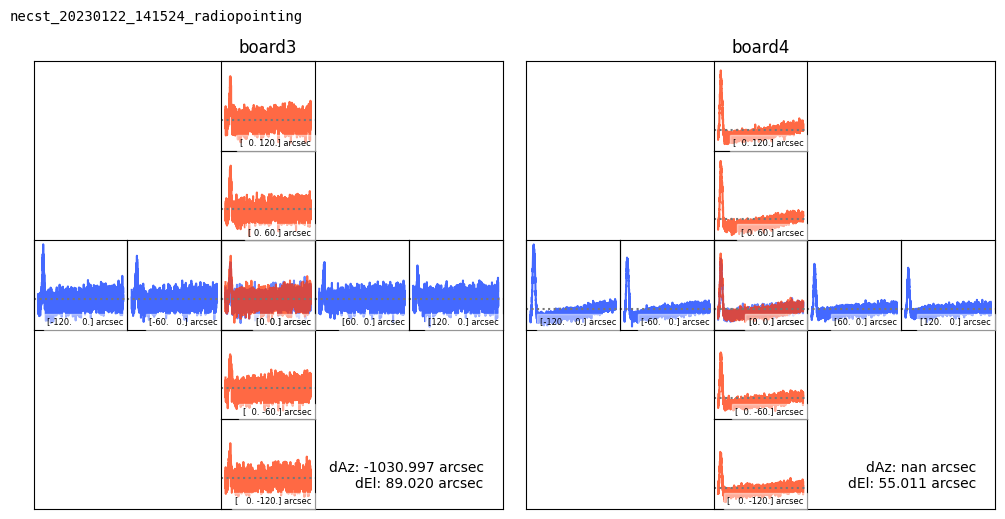

In [4]:
from necstdb import opendb

datapath="/Users/koutamac-academic/Necst_Analysis/nercst/necst_20230122_141524_radiopointing"
#MyChange
#db=necstdb.opendb(datapath)
db=opendb(datapath)
#print(db.list_tables())

data_encoder = db.open_table("necst-OMU1P85M-ctrl-antenna-encoder").read(astype="pandas")

start_time=data_encoder.time.values[-1]

_12 = channel("12CO_J2-1", 10 * u.km/u.s, "Orion_KL", obstime=start_time)
_13 = channel("13CO_J2-1", 10 * u.km/u.s, "Orion_KL", obstime=start_time, freq_2nd_lo=6.5 * u.GHz)

radio_pointing(
    "/Users/koutamac-academic/Necst_Analysis/nercst/necst_20230122_141524_radiopointing", 
    "/Users/koutamac-academic/Necst_Analysis/nercst/necst_20230122_141524_radiopointing/pt_orikl.obs", 
    specrange=[slice(int(_13) - 1000, int(_13) + 1000), slice(int(_12) - 1000, int(_12) + 1000)]
    )